# Análisis Exploratorio de Imágenes (EDA)

En esta sección se lleva a cabo un análisis exploratorio de los datos visuales proporcionados por el dataset ODIR-5K, cuyo objetivo principal es la detección automática de patologías oculares mediante aprendizaje profundo. El conjunto de datos incluye imágenes de fondo de ojo (retinografías) correspondientes a ambos ojos (izquierdo y derecho) de cada paciente, junto con sus respectivas etiquetas diagnósticas.

El propósito de este análisis es examinar la estructura, calidad y disponibilidad de las imágenes, así como identificar posibles inconsistencias, variaciones en el tamaño o el formato, diferencias de contraste o brillo, y cualquier otra característica relevante que pueda impactar en la fase de preprocesamiento y entrenamiento del modelo.

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
import os 
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from scipy.stats import ttest_ind

### Carga y vista general dataset
En este apartado se realiza la carga inicial del dataset ODIR-5K y una exploración básica de su contenido.

In [4]:
# Carga del dataset
df = pd.read_csv("../full_df.csv")

# Dimendión y primeras filas del dataset
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (6392, 19)


ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

In [ ]:
# Información básica del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [ ]:
# Conteo total de IDs únicos vs total filas
total_rows = df.shape[0]
unique_ids = df['ID'].nunique()

print(f"Total rows: {total_rows}")
print(f"Unique patient IDs: {unique_ids}")

Total rows: 6392
Unique patient IDs: 3358


Algunos pacientes solo disponen de una imagen de un ojo (ya sea el izquierdo o el derecho), ya que el conjunto de datos no siempre incluye ambas imágenes oculares para cada individuo.

### Análisis del tamaño y orientación de las imágenes

En esta sección se analizan las dimensiones (alto, ancho y número de canales) de las imágenes del dataset. Este análisis permite identificar la variedad de tamaños presentes, detectar posibles inconsistencias y establecer criterios adecuados para el preprocesamiento y la normalización de las imágenes antes del entrenamiento del modelo.


In [ ]:
# Ruta de las imágenes
image_dir = "../ODIR-5K/ODIR-5K/Training Images"

In [3]:
# Exploración tamaños de imagen
def get_image_sizes(image_paths):
    """
    Analiza las rutas de los archivos de imagen para extraer sus dimensiones e identificar imágenes corruptas.

    Parámetros:
        image_paths (lista de str): Lista de rutas completas a los archivos de imagen.

    Devuelve:
        size_counts: Tamaños de imagen (H, W, C) como claves y su frecuencia como valores.
        corrupted: Lista de rutas de archivos correspondientes a imágenes que no se pudieron leer.
    """
    sizes = []
    corrupted = []

    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            h, w, c = img.shape
            sizes.append((h, w, c))
        else:
            corrupted.append(path)

    size_counts = Counter(sizes)
    return size_counts, corrupted

Se imprime un resumen con los 15 tamaños de imagen más comunes y el número total de imágenes corruptas identificadas.

In [8]:
image_paths = df['filename'].apply(lambda x: os.path.join(image_dir, x)).tolist()

size_counts, corrupted_images = get_image_sizes(image_paths)

print("Most common image sizes:\n")
for size, count in size_counts.most_common(15):
    print(f"{size}: {count} images")

print(f"\nNumber of corrupted images: {len(corrupted_images)}")

Most common image sizes:

(1728, 2592, 3): 1982 images
(1536, 2048, 3): 489 images
(1728, 2304, 3): 392 images
(1934, 1956, 3): 379 images
(1824, 2736, 3): 325 images
(1444, 1444, 3): 254 images
(2304, 3456, 3): 243 images
(1984, 2976, 3): 206 images
(1296, 1936, 3): 198 images
(1152, 1536, 3): 192 images
(2448, 3264, 3): 166 images
(2056, 2124, 3): 144 images
(2592, 3888, 3): 121 images
(2976, 2976, 3): 118 images
(2000, 2584, 3): 103 images

Number of corrupted images: 0


Se observa que las imágenes presentan una notable variabilidad en sus dimensiones, con más de 15 tamaños diferentes. El formato más frecuente es (1728, 2592, 3), presente en 1.982 imágenes, seguido por otras resoluciones como (1536, 2048, 3) y (1728, 2304, 3). Será necesario aplicar un proceso de redimensionado uniforme durante el preprocesamiento.

Esto permitirá:

- Establecer una entrada consistente para el modelo (por ejemplo, redes convolucionales como ResNet o EfficientNet requieren una resolución fija).

- Aumentar la eficiencia computacional al reducir el tamaño de las imágenes más grandes.

- Evitar errores o inconsistencias en los DataLoaders si se trabaja con batches de imágenes.

Por otro lado, no se han identificado imágenes corruptas, lo que confirma que todos los archivos pueden ser leídos correctamente y están disponibles para su procesamiento posterior.

In [ ]:
# Muestra una selección aleatoria de imágenes 
def show_random_images(df, image_dir, n=15):
    """
    Muestra una selección aleatoria de imágenes del conjunto de datos.

    Parámetros:
        df: DataFrame que contiene los nombres de archivo de las imágenes.
        image_dir (str): Directorio donde se almacenan las imágenes.
        n (int): Número de imágenes a mostrar.
    """
    sample = df.sample(n)

    cols = 5
    rows = n // cols + 1 

    plt.figure(figsize=(15, 3 * rows))

    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        path = image_dir + "/" + sample.iloc[i]['filename']
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.title(sample.iloc[i]['filename'])

    plt.tight_layout()
    plt.show()

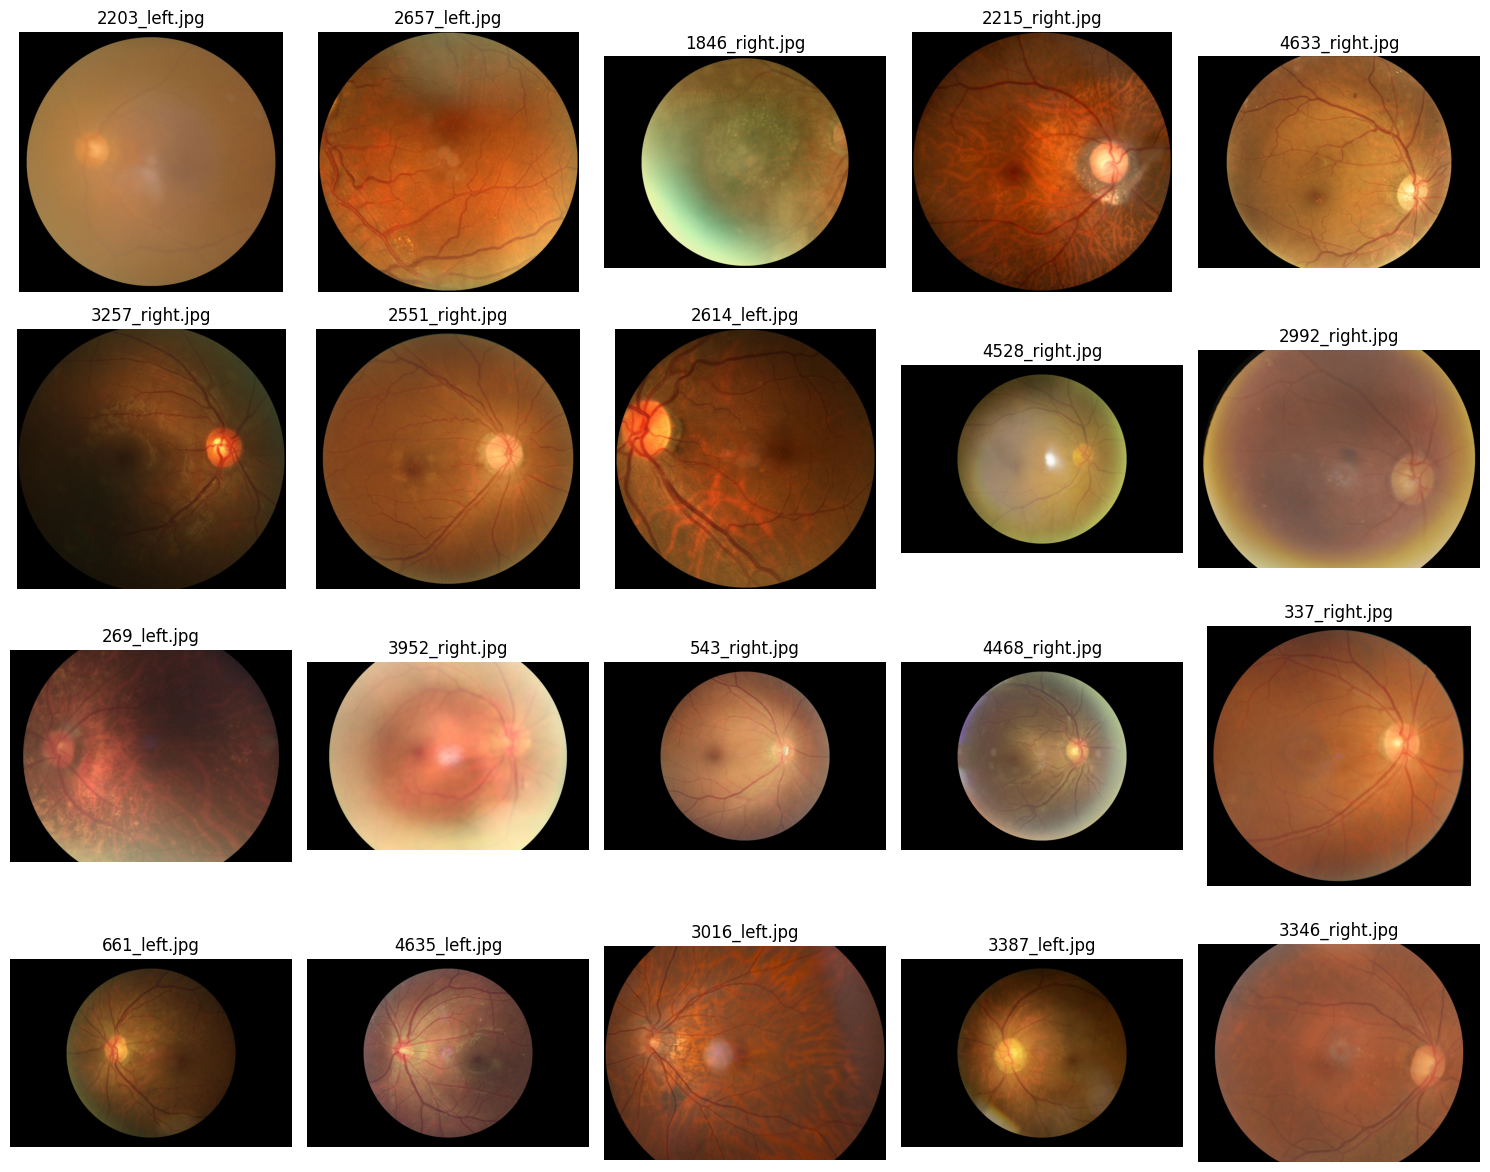

In [10]:
show_random_images(df, image_dir, n=20)

Se observa que las imágenes no son uniformes en la orientación; algunas muestras máculas a la izquierda y otras a la derecha. Algo que habrá que tener en cuenta en el preprocesamiento de las imágenes para que mácula y nervio óptico estén alineados en todas las muestras, por ejemplo aplicando `RandomHorizontalFlip`.

In [ ]:
test_dir = "../ODIR-5K/ODIR-5K/Testing Images" # Nota (Leti): ver si valen las imágenes de test para nuestro modelo (parece que no tienen asociados metadatos). Usar nombre genérico
# para este directorio (image_dir, está en celda 3).
# Nota (Sara): Estoy de acuerdo con Leti, si usamos las imagenes de Test estariamos haciendo data leak y eso es un fallo gordo.

In [ ]:
# Obtenemos solo archivos válidos (excluye carpetas ocultas) # (Leti): Ver si nos valen los datos de test
test_filenames = [f for f in os.listdir(test_dir) if not f.startswith('.')] # Nota (Leti): cambiaría test_filenames por image_filenames

df_test = pd.DataFrame({'filename': test_filenames})

In [ ]:
#Analisis de tamaño de subconjunto test 
image_sizes_test = []  # Nota(Leti): lo mismo, si finalmente solo usamos imágenes de Train, este análisis de Size ya está arriba, en la celda 5
corrupted_images_test = []

for filename in df_test['filename']:
    path = os.path.join(test_dir, filename)
    try:
        with Image.open(path) as img:
            image_sizes_test.append(img.size)
    except:
        corrupted_images_test.append(filename)

print("Different image sizes in TEST:")
for size in set(image_sizes_test):
    print(size)

print("Corrupted images in TEST:")
print(corrupted_images_test)

Different image sizes in TEST:
(3504, 2336)
(740, 718)
(2976, 2976)
(2414, 2416)
(2460, 1904)
(1956, 1934)
(1624, 1232)
(2008, 1508)
(940, 798)
(2584, 2000)
(1260, 946)
(1536, 1152)
(2976, 1984)
(1819, 1367)
(1936, 1296)
(3456, 2304)
(1470, 1137)
(2464, 1632)
(1468, 1469)
(3264, 2448)
(2100, 2100)
(2560, 1920)
(1280, 960)
(1920, 894)
(2624, 1968)
(963, 782)
(2584, 1990)
(1444, 1444)
(1440, 1080)
(3216, 2136)
(2196, 1960)
(2400, 2400)
(2304, 1728)
(3280, 2480)
(3888, 2592)
(2592, 1728)
(5184, 3456)
(2057, 1545)
(1747, 1312)
(1920, 1296)
(1468, 1300)
(2736, 1824)
(2080, 2090)
(725, 716)
(3456, 3456)
(2992, 2000)
(2048, 1536)
(1380, 1382)
(2588, 1956)
(2592, 1944)
(1920, 1088)
(2124, 2056)
(1471, 1475)
(1600, 1400)
(1725, 1721)
(1483, 1114)
(2960, 2935)
(962, 777)
(4288, 2848)
(2038, 1531)
Corrupted images in TEST:
[]


In [ ]:

#Realizo una comparacion entre Size Train VS Test
print("\n--- COMPARACIÓN ---")   # Nota (Leti): igual, ver si usamos solo train
print("Total TRAINING images:", len(size_counts))
print("Total TESTING images:", len(image_sizes_test))

print("\nUnique sizes in TRAINING:", set(size_counts))
print("Unique sizes in TESTING:", set(image_sizes_test))

# Tamaños presentes en train pero no en test
print("\nSizes in TRAINING but not in TESTING:")
print(set(size_counts) - set(image_sizes_test))

# Tamaños presentes en test pero no en train
print("Sizes in TESTING but not in TRAINING:")
print(set(image_sizes_test) - set(size_counts))


--- COMPARACIÓN ---
Total TRAINING images: 97
Total TESTING images: 1000

Unique sizes in TRAINING: {(1471, 1470, 3), (784, 949, 3), (788, 929, 3), (2400, 2400, 3), (1088, 1920, 3), (2000, 2992, 3), (1934, 1956, 3), (2350, 2785, 3), (1296, 1936, 3), (1470, 1469, 3), (785, 972, 3), (705, 758, 3), (790, 930, 3), (783, 960, 3), (3000, 4496, 3), (718, 770, 3), (2056, 2124, 3), (1721, 1725, 3), (1958, 2196, 3), (2000, 2584, 3), (1472, 1470, 3), (1990, 2584, 3), (805, 924, 3), (2080, 2090, 3), (2448, 3696, 3), (2480, 3280, 3), (1919, 2480, 3), (785, 951, 3), (1065, 1320, 3), (1545, 2057, 3), (1769, 2286, 3), (1085, 1375, 3), (2304, 3456, 3), (2448, 3264, 3), (1920, 2560, 3), (1951, 2584, 3), (1728, 2304, 3), (1609, 2142, 3), (2592, 3888, 3), (1472, 1468, 3), (2416, 2414, 3), (1536, 2048, 3), (1300, 1468, 3), (799, 925, 3), (2976, 2976, 3), (1260, 1677, 3), (2336, 3504, 3), (1470, 1468, 3), (3456, 3456, 3), (2136, 3216, 3), (1824, 2736, 3), (1984, 2976, 3), (1444, 1620, 3), (1677, 2232, 3), 

ANALISIS DETALLADO DE SHAPE 

A la vista de la amplia disparidad de tamaños en los subconjuntos de Train & Test y entre los mismos, paso a realizar un breve analisis de frecuencia por shape. Instalo y empleo la libreria CV2 como libreria mejor orientada para un proyecto de DL ( OJO : hay que tener presente el orden de color que es BGR en vez de RGB)

In [ ]:
#Frecuencia por shape Training # (Leti): si vamos ausar solo train, este análisis ya está en la celda 8
train_dir = "../ODIR-5K/ODIR-5K/Training Images"

df_train = pd.DataFrame({'filename': [f for f in os.listdir(train_dir) if not f.startswith('.')]})
df_train['path'] = df_train['filename'].apply(lambda x: os.path.join(train_dir, x))

#Tamaño   
df_train['shape'] = df_train['path'].apply(lambda x: cv2.imread(x).shape if cv2.imread(x) is not None else None) #(Leti): se está leyendo la imagen dos veces. Igual con una función lo podemos optimizar.

#Filtral NULL 
df_train = df_train[df_train['shape'].notnull()] # Ojo! en la celda 3 ya hemos visto que no hay nulos.

# Frecuencia
train_shape_freq = df_train['shape'].value_counts()
print("\nFrecuencias de tamaños en TRAINING:")
print(train_shape_freq)


Frecuencias de tamaños en TRAINING:
shape
(1728, 2592, 3)    2146
(1536, 2048, 3)     524
(1728, 2304, 3)     424
(1934, 1956, 3)     390
(1824, 2736, 3)     344
                   ... 
(1085, 1375, 3)       1
(805, 924, 3)         1
(718, 770, 3)         1
(716, 727, 3)         1
(714, 764, 3)         1
Name: count, Length: 101, dtype: int64


In [ ]:
# (Sara): TO DO en preprocesamiento: Redimensionar todas las imagenes a la misma dimensión (p.e. 1728, 2592, 3 ??)
# (Leti): si vamos a usar una ResNet no podemos pasarle esos tamaños, deberían ser con los que la red está entrenada (224, 224). Creo que hay una manera de resimensionar sin deformar la imagen
# que es Resize + CenterCrop (mantiene el aspecto de la imagen original)

In [24]:
#Frecuencia por shape Test 
test_dir = "../ODIR-5K/ODIR-5K/Testing Images" 

df_test = pd.DataFrame({'filename': [f for f in os.listdir(test_dir) if not f.startswith('.')]})
df_test['path'] = df_test['filename'].apply(lambda x: os.path.join(test_dir, x))
df_test['shape'] = df_test['path'].apply(lambda x: cv2.imread(x).shape if cv2.imread(x) is not None else None)
df_test = df_test[df_test['shape'].notnull()]

test_shape_freq = df_test['shape'].value_counts()
print("\nFrecuencias de tamaños en TESTING:")
print(test_shape_freq)


Frecuencias de tamaños en TESTING:
shape
(1728, 2592, 3)    274
(1728, 2304, 3)     88
(1536, 2048, 3)     80
(1296, 1936, 3)     38
(1824, 2736, 3)     38
(1984, 2976, 3)     36
(2304, 3456, 3)     36
(1934, 1956, 3)     34
(2592, 3888, 3)     32
(1152, 1536, 3)     30
(2448, 3264, 3)     30
(2000, 2992, 3)     28
(2976, 2976, 3)     26
(1444, 1444, 3)     21
(1944, 2592, 3)     20
(2336, 3504, 3)     18
(1382, 1380, 3)     16
(2000, 2584, 3)     14
(2480, 3280, 3)     14
(2100, 2100, 3)     10
(2400, 2400, 3)      8
(1632, 2464, 3)      8
(2056, 2124, 3)      8
(1721, 1725, 3)      8
(1920, 2560, 3)      6
(3456, 5184, 3)      6
(2935, 2960, 3)      6
(1137, 1470, 3)      6
(2136, 3216, 3)      4
(1296, 1920, 3)      4
(1960, 2196, 3)      4
(894, 1920, 3)       4
(1990, 2584, 3)      4
(960, 1280, 3)       4
(1300, 1468, 3)      2
(3456, 3456, 3)      2
(1904, 2460, 3)      2
(1080, 1440, 3)      2
(1232, 1624, 3)      2
(2848, 4288, 3)      2
(1400, 1600, 3)      2
(1545, 2057, 3)

In [25]:
#Comparacion de frecuencias entre Train y Test con sumatorio de Shape y Acumulado 

# Creacion de dataframes para train y test.   # Nota (Leti): igual, no usaría Test, por lo que no haría falta esta comparación. 
df_train_shapes = train_shape_freq.reset_index()
df_train_shapes.columns = ['shape', 'count_train']

df_test_shapes = test_shape_freq.reset_index()
df_test_shapes.columns = ['shape', 'count_test']

# Fusion
df_shapes = pd.merge(df_train_shapes, df_test_shapes, on='shape', how='outer').fillna(0)

# Orden
df_shapes['total'] = df_shapes['count_train'] + df_shapes['count_test']
df_shapes = df_shapes.sort_values('total', ascending=False)

# Acumulado
df_shapes['acumulado'] = df_shapes['total'].cumsum()

df_shapes.iloc[0:50]

shape  count_train  count_test   total  acumulado
74   (1728, 2592, 3)       2146.0       274.0  2420.0     2420.0
66   (1536, 2048, 3)        524.0        80.0   604.0     3024.0
73   (1728, 2304, 3)        424.0        88.0   512.0     3536.0
82   (1934, 1956, 3)        390.0        34.0   424.0     3960.0
76   (1824, 2736, 3)        344.0        38.0   382.0     4342.0
41   (1296, 1936, 3)        284.0        38.0   322.0     4664.0
100  (2304, 3456, 3)        258.0        36.0   294.0     4958.0
50   (1444, 1444, 3)        267.0        21.0   288.0     5246.0
89   (1984, 2976, 3)        212.0        36.0   248.0     5494.0
37   (1152, 1536, 3)        198.0        30.0   228.0     5722.0
105  (2448, 3264, 3)        170.0        30.0   200.0     5922.0
108  (2592, 3888, 3)        124.0        32.0   156.0     6078.0
95   (2056, 2124, 3)        146.0         8.0   154.0     6232.0
112  (2976, 2976, 3)        124.0        26.0   150.0     6382.0
83   (1944, 2592, 3)        102.0        20.0   122.0     6504.0
91   (2000, 2584, 3)        107.0        14.0   121.0     6625.0
92   (2000, 2992, 3)         80.0        28.0   108.0     6733.0
45   (1382, 1380, 3)         74.0        16.0    90.0     6823.0
40   (1296, 1920, 3)         78.0         4.0    82.0     6905.0
28    (894, 1920, 3)         74.0         4.0    78.0     6983.0
103  (2400, 2400, 3)         68.0         8.0    76.0     7059.0
111  (2935, 2960, 3)         69.0         6.0    75.0     7134.0
38   (1232, 1624, 3)         64.0         2.0    66.0     7200.0
70   (1632, 2464, 3)         56.0         8.0    64.0     7264.0
115  (3456, 5184, 3)         52.0         6.0    58.0     7322.0
81   (1920, 2560, 3)         52.0         6.0    58.0     7380.0
101  (2336, 3504, 3)         38.0        18.0    56.0     7436.0
107  (2480, 3280, 3)         32.0        14.0    46.0     7482.0
36   (1137, 1470, 3)         28.0         6.0    34.0     7516.0
113  (3000, 4496, 3)         32.0         0.0    32.0     7548.0
104  (2416, 2414, 3)         30.0         2.0    32.0     7580.0
98   (2100, 2100, 3)         20.0        10.0    30.0     7610.0
106  (2448, 3696, 3)         30.0         0.0    30.0     7640.0
99   (2136, 3216, 3)         18.0         4.0    22.0     7662.0
27    (893, 1920, 3)         20.0         0.0    20.0     7682.0
96   (2080, 2090, 3)         20.0         0.0    20.0     7702.0
49   (1424, 2144, 3)         20.0         0.0    20.0     7722.0
109  (2848, 4288, 3)         16.0         2.0    18.0     7740.0
34   (1088, 1920, 3)         14.0         2.0    16.0     7756.0
84   (1951, 2584, 3)         16.0         0.0    16.0     7772.0
30    (960, 1280, 3)         12.0         4.0    16.0     7788.0
86   (1958, 2196, 3)         14.0         0.0    14.0     7802.0
79   (1904, 2460, 3)         10.0         2.0    12.0     7814.0
72   (1721, 1725, 3)          4.0         8.0    12.0     7826.0
114  (3456, 3456, 3)         10.0         2.0    12.0     7838.0
0      (188, 250, 3)         10.0         0.0    10.0     7848.0
90   (1990, 2584, 3)          6.0         4.0    10.0     7858.0
1      (316, 320, 3)         10.0         0.0    10.0     7868.0
42   (1300, 1468, 3)          6.0         2.0     8.0     7876.0
71   (1677, 2232, 3)          8.0         0.0     8.0     7884.0

In [ ]:
#Preparacion de DataFrames para visualizacion # (Leti): valorar si usamos conjunto de Test.

df_train_shapes = train_shape_freq.reset_index()
df_train_shapes.columns = ['shape', 'count_train']

df_test_shapes = test_shape_freq.reset_index()
df_test_shapes.columns = ['shape', 'count_test']

df_shapes = pd.merge(df_train_shapes, df_test_shapes, on='shape', how='outer').fillna(0)

df_shapes['count_train'] = df_shapes['count_train'].astype(int)
df_shapes['count_test'] = df_shapes['count_test'].astype(int)

df_shapes['total'] = df_shapes['count_train'] + df_shapes['count_test']
df_shapes = df_shapes.sort_values('total', ascending=False)

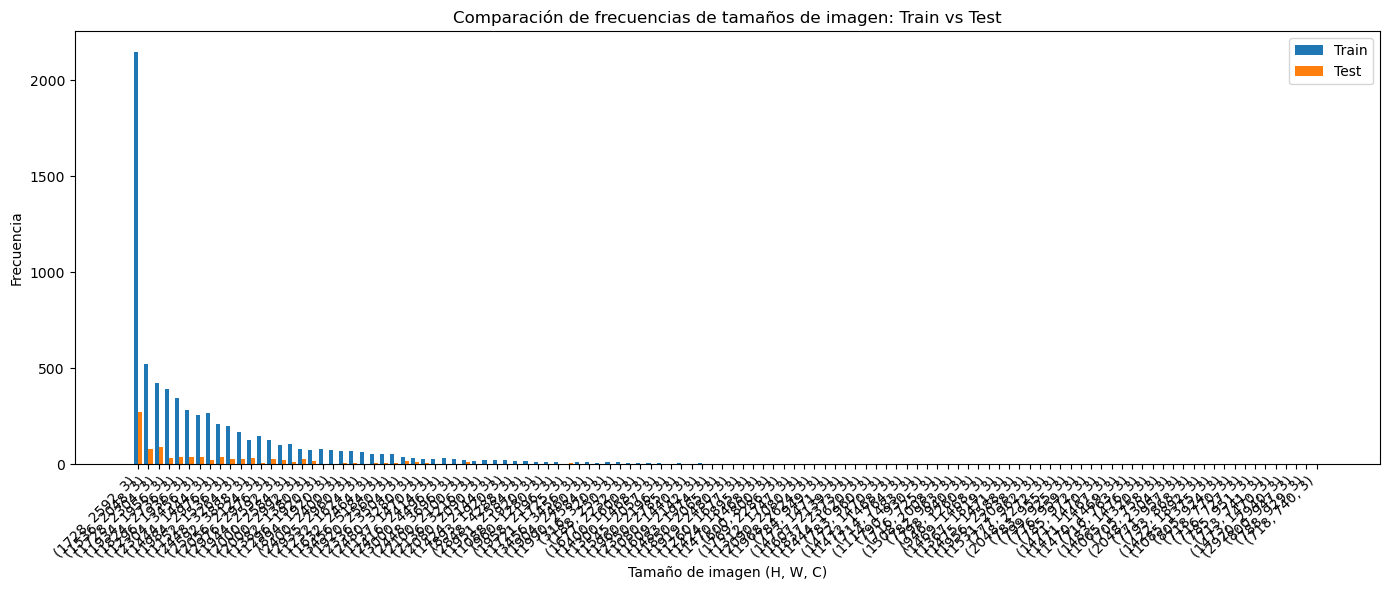

In [ ]:
#Graficas de shapes Train vs Test 

# eje X
df_shapes['shape_str'] = df_shapes['shape'].astype(str) # Nota (Leti): Creo este gráfico es complicado de visualizar por la cantidad de tamaños diferentes.
# esta gráfica que información nos aportaría? porque queremos el tamaño más frecuente para redimensionar a ese tamaño? aunque igual no podemos si usamos una ResNet.. sería solo a modo informativo?

x = np.arange(len(df_shapes))  
width = 0.4  

plt.figure(figsize=(14, 6))

plt.bar(x - width/2, df_shapes['count_train'], width, label='Train')
plt.bar(x + width/2, df_shapes['count_test'], width, label='Test')

plt.xlabel('Tamaño de imagen (H, W, C)')
plt.ylabel('Frecuencia')
plt.title('Comparación de frecuencias de tamaños de imagen: Train vs Test')
plt.xticks(x, df_shapes['shape_str'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Definición de acumulado para visualización
df_shapes['acumulado'] = df_shapes['total'].cumsum()

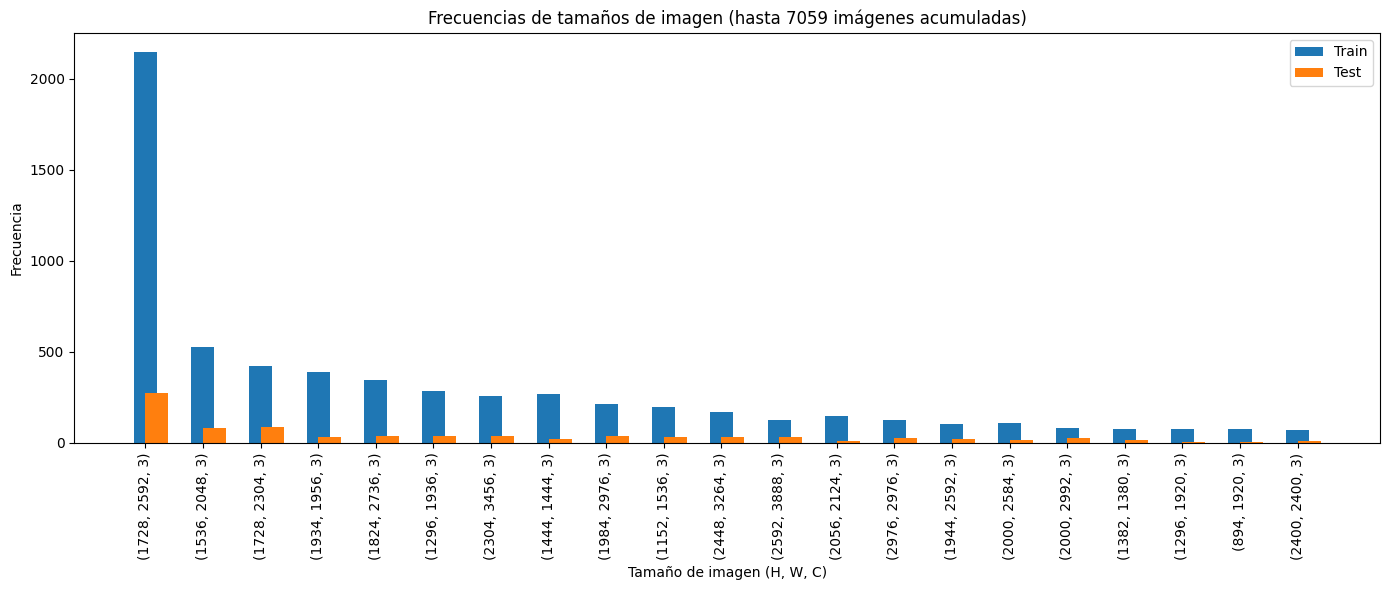

In [ ]:
# Graficas de shapes Train vs Test mas claro # (Leti): yo dejaría esta gráfica, más clara y fácil de interpretar.

# DataFrame hasta el acumulado de 7059  #(leti): ino entiendo bien para qué ponemos este valor de acumulado (lo vemos), creo que no hace falta. Si usamos solo train, hay que cambiar este df_shapes
df_cut = df_shapes[df_shapes['acumulado'] <= 7059]

plt.figure(figsize=(14, 6))
x_labels = [str(shape) for shape in df_cut['shape']]
x = range(len(df_cut))

plt.bar(x, df_cut['count_train'], width=0.4, label='Train', align='center')
plt.bar(x, df_cut['count_test'], width=0.4, label='Test', align='edge')

plt.xticks(x, x_labels, rotation=90)
plt.xlabel("Tamaño de imagen (H, W, C)")
plt.ylabel("Frecuencia")
plt.title("Frecuencias de tamaños de imagen (hasta 7059 imágenes acumuladas)")
plt.legend()
plt.tight_layout()

plt.show()

### Análisis de color de las imágenes

Considero valorar posibles fluctuaciones de brillo , contraste o colores para poder posteriormente en la etapa de preprocesamiento considerarlo a efectos de normalizacion o data aumentation.

Se hace especialmente relevante para los casos de deteccion de Retinopatia Diabetica y Edema Macular Diabetico la informacion del canal rojo y verde para detectar microhemorragias asi como exudados

Se analiza en primer lugar los grises para detectar sobreeexposicion , contraste y dominancia de fondos negros. 

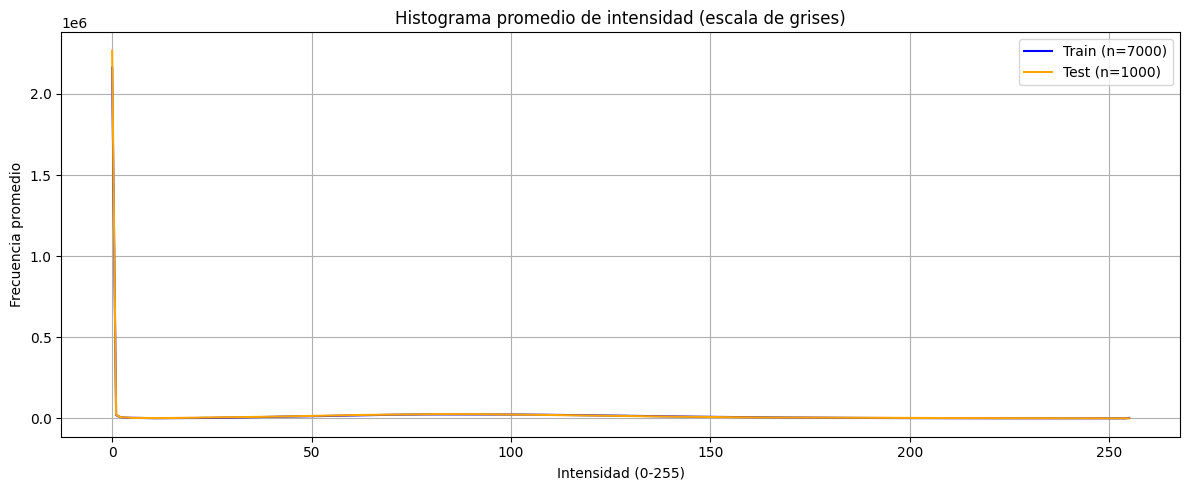

In [ ]:
# Graficas de grises     

def compute_grayscale_histogram(directorio):
    """
    Calcula el histograma promedio de niveles de gris para todas las imágenes JPG de un directorio.

    Parámetros:
        directorio (str): Ruta al directorio que contiene las imágenes en formato .jpg.

    Devuelve:
        hist_total (np.ndarray): Histograma promedio de niveles de gris (array de 256 valores).
        num_imagenes (int): Número de imágenes procesadas correctamente.
    """
    image_paths = [os.path.join(directorio, fname) for fname in os.listdir(directorio) if fname.endswith('.jpg')]
    hist_total = np.zeros(256)

    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()
        hist_total += hist

    if len(image_paths) > 0:
        hist_total /= len(image_paths)  
    return hist_total, len(image_paths)


train_dir = "../ODIR-5K/ODIR-5K/Training Images"
test_dir  = "../ODIR-5K/ODIR-5K/Testing Images"

# Histogramas
hist_train, n_train = compute_grayscale_histogram(train_dir)
hist_test, n_test   = compute_grayscale_histogram(test_dir)


plt.figure(figsize=(12, 5))
plt.plot(hist_train, label=f'Train (n={n_train})', color='blue')
plt.plot(hist_test, label=f'Test (n={n_test})', color='orange')
plt.title("Histograma promedio de intensidad (escala de grises)")
plt.xlabel("Intensidad (0-255)")
plt.ylabel("Frecuencia promedio")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

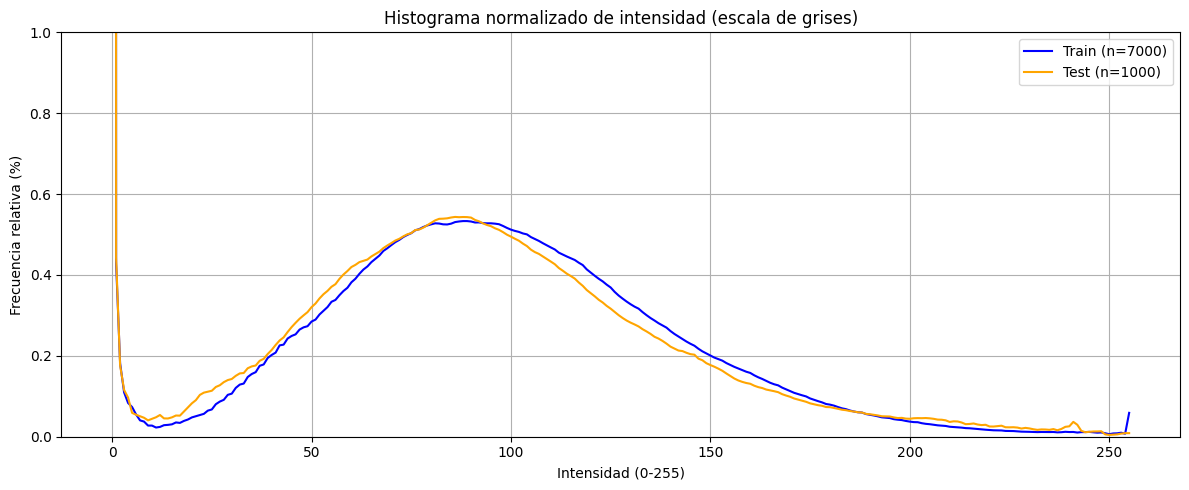

In [ ]:
#Graficas de grises de una manera mas clara normalizando el histograma

def compute_grayscale_histogram(directorio):
    """
    Calcula el histograma promedio y normalizado de niveles de gris para todas las imágenes JPG de un directorio.

    Parámetros:
        directorio (str): Ruta al directorio que contiene las imágenes en formato .jpg.

    Devuelve:
        hist_total (np.ndarray): Histograma normalizado de niveles de gris (array de 256 valores en porcentaje).
        num_imagenes (int): Número total de imágenes procesadas correctamente.
    """
    image_paths = [os.path.join(directorio, fname) for fname in os.listdir(directorio) if fname.endswith('.jpg')]
    hist_total = np.zeros(256)

    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()
        hist_total += hist

    if len(image_paths) > 0:
        hist_total /= hist_total.sum()  
        hist_total *= 100  
    return hist_total, len(image_paths)


train_dir = "../ODIR-5K/ODIR-5K/Training Images"
test_dir  = "../ODIR-5K/ODIR-5K/Testing Images"

# Histogramas
hist_train, n_train = compute_grayscale_histogram(train_dir)
hist_test, n_test   = compute_grayscale_histogram(test_dir)


plt.figure(figsize=(12, 5))
plt.plot(hist_train, label=f'Train (n={n_train})', color='blue')
plt.plot(hist_test, label=f'Test (n={n_test})', color='orange')
plt.title("Histograma normalizado de intensidad (escala de grises)")
plt.xlabel("Intensidad (0-255)")
plt.ylabel("Frecuencia relativa (%)")
plt.ylim(0, 1.0)  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Las intensidades medias situadas aproximadamente en el rango de 50 a 150 probablemente correspondan a la región central del fondo de ojo (retina), donde se concentra la mayor parte de la información clínica relevante. En cambio, las intensidades más bajas están asociadas a zonas oscuras o al fondo negro de la imagen, que no aportan valor diagnóstico.

Con el objetivo de resaltar las estructuras relevantes y mejorar el contraste global entre las regiones informativas y las no informativas, se podría aplicar la transformación `ColorJitter` durante el preprocesamiento. Esta técnica permite ajustar dinámicamente el brillo, contraste y saturación, favoreciendo así la detección de características patológicas sutiles.

A continuación se realiza el analisis de los canales de Rojo, Verder y Azul

In [ ]:

train_dir = "../ODIR-5K/ODIR-5K/Training Images" 
test_dir  = "../ODIR-5K/ODIR-5K/Testing Images"

train_image_paths = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith('.jpg')]
test_image_paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.jpg')]

In [ ]:
# Analisis de canales RGB

def compute_rgb_histogram(image_paths): # (Leti): he incluido el canal B (azul)
    """
    Calcula el histograma promedio de los canales RGB (Rojo, Verde y Azul) 
    a partir de una lista de imágenes.

    Parámetros:
        image_paths (list of str): Rutas de las imágenes en formato .jpg.

    Devuelve:
        b_hist, g_hist, r_hist (np.ndarray): Histogramas promedio de los canales Azul, Verde y Rojo.
    """

    b_hist = np.zeros(256)
    g_hist = np.zeros(256)
    r_hist = np.zeros(256)

    for path in tqdm(image_paths):
        img = cv2.imread(path)
        if img is None:
            continue

        b_channel = img[:, :, 0]
        g_channel = img[:, :, 1]
        r_channel = img[:, :, 2]

        b_hist += cv2.calcHist([b_channel], [0], None, [256], [0, 256]).ravel()
        g_hist += cv2.calcHist([g_channel], [0], None, [256], [0, 256]).ravel()
        r_hist += cv2.calcHist([r_channel], [0], None, [256], [0, 256]).ravel()

    # Promedio (evita división por 0 si hay imágenes nulas)
    num_valid_images = len([p for p in image_paths if cv2.imread(p) is not None])
    if num_valid_images > 0:
        b_hist /= num_valid_images
        g_hist /= num_valid_images
        r_hist /= num_valid_images

    return b_hist, g_hist, r_hist


In [ ]:

train_b_hist, train_g_hist, train_r_hist = compute_rgb_histogram(train_image_paths)
test_b_hist, test_g_hist, test_r_hist = compute_rgb_histogram(test_image_paths)

100%|██████████| 1000/1000 [00:29<00:00, 33.74it/s]


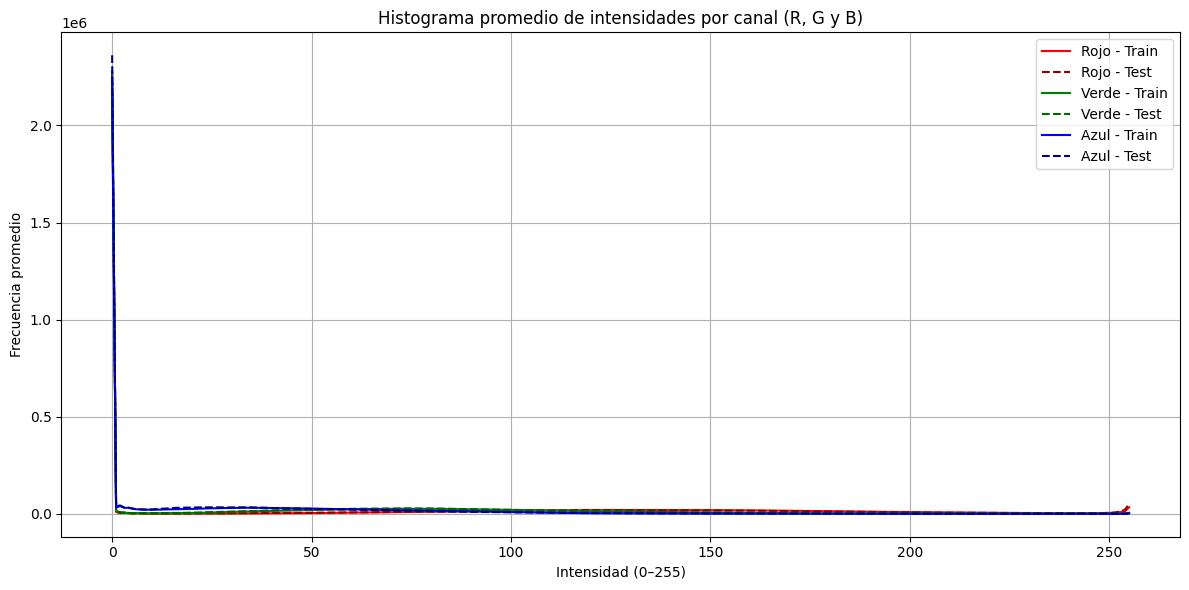

In [37]:
plt.figure(figsize=(12, 6))

# Canal Rojo
plt.plot(train_r_hist, color='red', label='Rojo - Train')
plt.plot(test_r_hist, color='darkred', linestyle='--', label='Rojo - Test')

# Canal Verde
plt.plot(train_g_hist, color='green', label='Verde - Train')
plt.plot(test_g_hist, color='darkgreen', linestyle='--', label='Verde - Test')

# Canal Azul # (Leti): he actualizado el código para incluir el canal azul
plt.plot(train_b_hist, color='blue', label='Azul - Train')
plt.plot(test_b_hist, color='navy', linestyle='--', label='Azul - Test')

plt.title("Histograma promedio de intensidades por canal (R, G y B)")
plt.xlabel("Intensidad (0–255)")
plt.ylabel("Frecuencia promedio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Normalizamos los histogramas de color RGB para el conjunto de datos, de forma que las frecuencias se expresen en porcentaje. Luego, se grafican los histogramas normalizados para los canales Rojo, Verde y Azul, permitiendo ver visualmente la distribución de intensidades de color. 

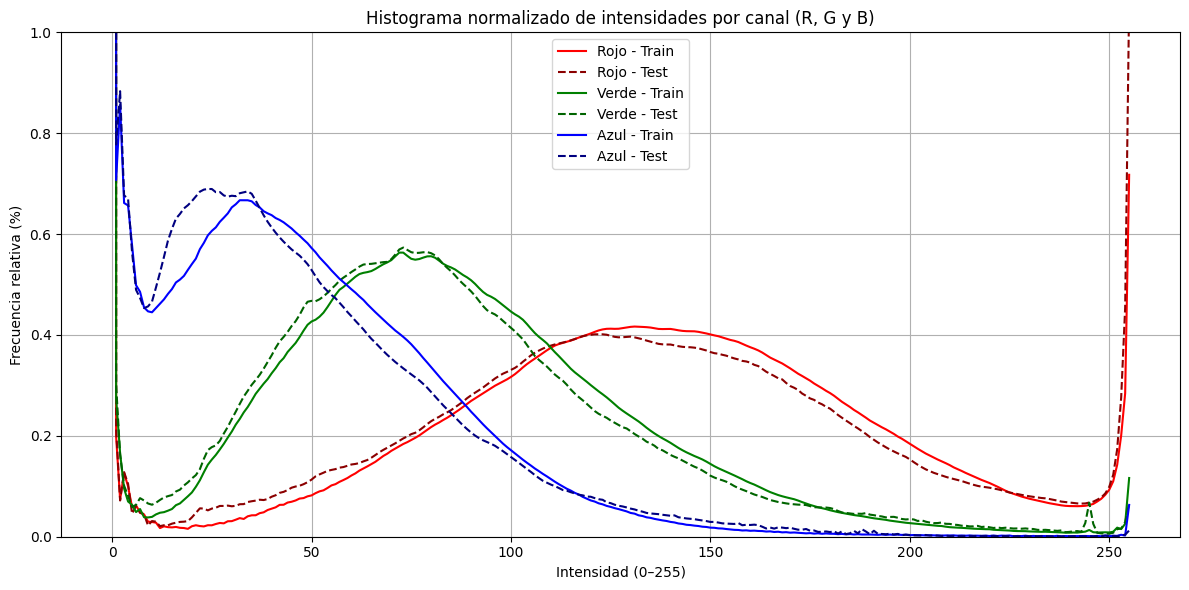

In [38]:
# histograma normalizado para colores R, G y B # (Leti): lo mismo, actualizo código con el canal azul
def normalizar_histograma(hist):
    return hist / hist.sum() * 100  

# Normalizamos todos los canales
train_r_hist_norm = normalizar_histograma(train_r_hist)
test_r_hist_norm  = normalizar_histograma(test_r_hist)

train_g_hist_norm = normalizar_histograma(train_g_hist)
test_g_hist_norm  = normalizar_histograma(test_g_hist)

train_b_hist_norm = normalizar_histograma(train_b_hist)
test_b_hist_norm  = normalizar_histograma(test_b_hist)

# Graficamos los histogramas normalizados
plt.figure(figsize=(12, 6))

# Canal Rojo
plt.plot(train_r_hist_norm, color='red', label='Rojo - Train')
plt.plot(test_r_hist_norm, color='darkred', linestyle='--', label='Rojo - Test')

# Canal Verde
plt.plot(train_g_hist_norm, color='green', label='Verde - Train')
plt.plot(test_g_hist_norm, color='darkgreen', linestyle='--', label='Verde - Test')

# Canal Azul
plt.plot(train_b_hist_norm, color='blue', label='Azul - Train')
plt.plot(test_b_hist_norm, color='navy', linestyle='--', label='Azul - Test')

plt.title("Histograma normalizado de intensidades por canal (R, G y B)")
plt.xlabel("Intensidad (0–255)")
plt.ylabel("Frecuencia relativa (%)")
plt.ylim(0, 1.0) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


En los tres canales (R, G y B), el pico de frecuencia se encuentra cerca de la intensidad 0, lo que indica, de nuevo, una fuerte presencia del fondo negro en las imágenes. Esto podría hacer que el modelo aprenda patrones relacionados con el fondo en lugar de centrarse en las zonas relevantes de la retina. Por ello, durante el preprocesamiento se aplicarán técnicas que reduzcan esta dependencia del fondo y mejoren la robustez del modelo (evitar que aprenda del ruido). Además, se observa que el canal azul (B) presenta menor variabilidad e intensidad relativa, lo que sugiere que podría contener menos información útil comparado con los canales rojo (R) y verde (G).

A continuación  se realiza el análisis de imágenes oscuras y de bajo contraste.

Analizando imágenes: 100%|██████████| 7000/7000 [02:57<00:00, 39.52it/s]



=== RESUMEN ===
Dark Images: 516 (7.4%)
Low Contrast Images: 204 (2.9%)
Bright Images: 143 (2.0%)
High Contrast Images: 91 (1.3%)


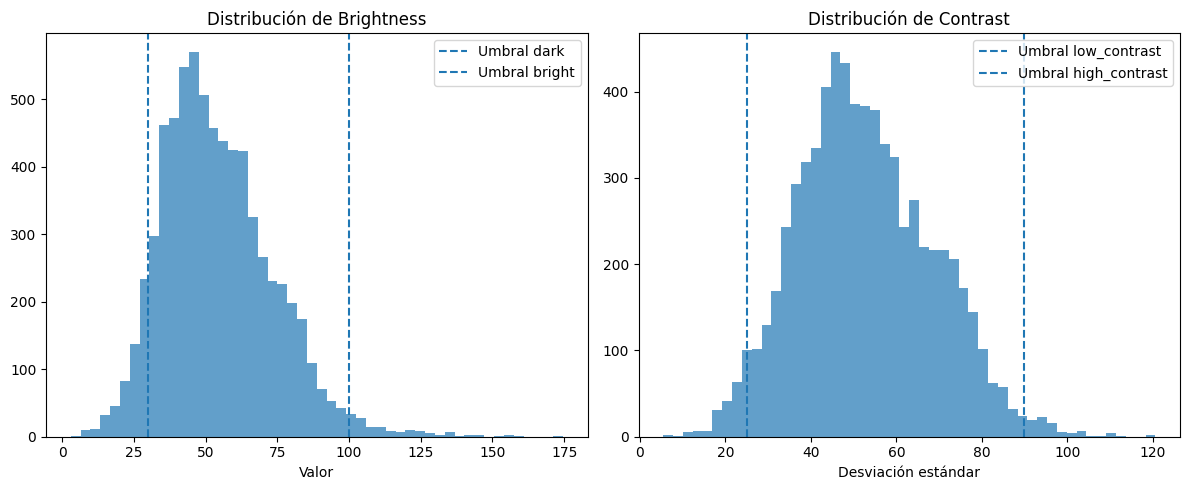

In [4]:
# (Sara): Añado detección de imágenes oscuras o con bajo contraste

# Umbrales (ajustables) los valores se han ajustado tras varias pruebas
THRESHOLDS = {
    'dark': 30,
    'low_contrast': 25,
    'bright': 100,
    'high_contrast': 90
}

def analyze_image(image_path):
    """Analiza calidad de imagen en una sola pasada"""
    img = cv2.imread(image_path)
    if img is None: return None
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    brightness, contrast = np.mean(gray), np.std(gray)
    
    return {
        'brightness': brightness,
        'contrast': contrast,
        'is_dark': brightness < THRESHOLDS['dark'],
        'is_bright': brightness > THRESHOLDS['bright'],
        'is_low_contrast': contrast < THRESHOLDS['low_contrast'],
        'is_high_contrast': contrast > THRESHOLDS['high_contrast'],
        'hist': cv2.calcHist([gray], [0], None, [256], [0, 256]).ravel()
    }

def analyze_dataset(image_dir, sample_size=None):
    """Versión compacta del análisis de dataset"""
    paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
    paths = random.sample(paths, sample_size) if sample_size else paths
    
    categories = ['dark', 'low_contrast', 'bright', 'high_contrast']
    results = {k: [] for k in categories}
    results['all'] = []
    
    for path in tqdm(paths, desc="Analizando imágenes"):
        if analysis := analyze_image(path):
            results['all'].append(analysis)
            for cat in categories:
                if analysis[f'is_{cat}']: results[cat].append(path)
    
    stats = {
        'total': len(results['all']),
        **{f'{k}_images': len(v) for k, v in results.items() if k != 'all'},
        'mean_brightness': np.mean([r['brightness'] for r in results['all']]),
        'mean_contrast': np.mean([r['contrast'] for r in results['all']]),
        **{f'{k}_paths': v for k, v in results.items() if k != 'all'}
    }
    
    return stats, results['all']

# Visualización compacta
def plot_stats(results):
    metrics = ['brightness', 'contrast']
    thresholds = {
        'brightness': ('dark', 'bright'), 
        'contrast': ('low_contrast', 'high_contrast')
    }
    
    plt.figure(figsize=(12, 5))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 2, i)
        plt.hist([r[metric] for r in results], bins=50, alpha=0.7)
        for t in thresholds[metric]:
            plt.axvline(x=THRESHOLDS[t], linestyle='--', label=f'Umbral {t}')
        plt.title(f'Distribución de {metric.capitalize()}')
        plt.xlabel('Valor' if metric == 'brightness' else 'Desviación estándar')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Uso
stats, results = analyze_dataset("../ODIR-5K/ODIR-5K/Training Images")
print("\n=== RESUMEN ===")
[print(f"{k.replace('_', ' ').title()}: {v} ({v/stats['total']:.1%})") 
 for k, v in stats.items() if k.endswith('images')]

plot_stats(results)

Parece que el contraste medio y el brillo son suficientemente altos, lo que habría que tener en cuenta para no aplicar transformaciones muy agresivas a todo el conjunto.

In [ ]:
#(David) Utilizo la misma tecnica de analisis de Sara para evaluar tambien el subconjunto Test. Tenemos un split "heredado" y minimizamos riesgos en esta fase del EDA si lo valoramos tambien. 
# (Leti): hay una dividión previa de los datos. El problema es que no hay metadatos asociados al conjunto de Tets (edad, género...), se puede ver con el full_df, en el caso de usar 
# un modelo multimodal, este conjunto de imágenes creo que no nos valdría (hay que verlo). Igualmente no deberíamos usar imággenes que usemos luego para Test en el EDA para tomar decisiones.

# Ruta a los directorios
train_dir = "../ODIR-5K/ODIR-5K/Training Images"
test_dir  = "../ODIR-5K/ODIR-5K/Testing Images"

# Analisis de calidad   
def analyze_image_quality(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)
    contrast = np.std(gray)
    
    DARK_THRESHOLD = 30
    LOW_CONTRAST_THRESHOLD = 35

    return {
        'is_dark': brightness < DARK_THRESHOLD,
        'is_low_contrast': contrast < LOW_CONTRAST_THRESHOLD,
        'brightness': brightness,
        'contrast': contrast
    }

# Función para analizar el conjunto 
def analyze_dataset(image_dir, sample_size=None):
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
    if sample_size:
        image_paths = random.sample(image_paths, sample_size)

    results = []
    for path in tqdm(image_paths, desc=f"Analizando imágenes en {os.path.basename(image_dir)}"):
        analysis = analyze_image_quality(path)
        if analysis:
            results.append(analysis)

    brightness_values = [r['brightness'] for r in results]
    contrast_values = [r['contrast'] for r in results]

    stats = {
        'total_images': len(results),
        'dark_images': sum(r['is_dark'] for r in results),
        'low_contrast_images': sum(r['is_low_contrast'] for r in results),
        'mean_brightness': np.mean(brightness_values),
        'mean_contrast': np.mean(contrast_values),
        'results': results
    }

    return stats

# Analisis train & test
stats_train = analyze_dataset(train_dir)
stats_test  = analyze_dataset(test_dir)

#Resultados individuales 
print("\n=== TRAIN ===")
print(f"Total imágenes: {stats_train['total_images']}")
print(f"Oscuras: {stats_train['dark_images']} ({stats_train['dark_images'] / stats_train['total_images']:.1%})")
print(f"Bajo contraste: {stats_train['low_contrast_images']} ({stats_train['low_contrast_images'] / stats_train['total_images']:.1%})")
print(f"Brillo medio: {stats_train['mean_brightness']:.1f}")
print(f"Contraste medio: {stats_train['mean_contrast']:.1f}")

print("\n=== TEST ===")
print(f"Total imágenes: {stats_test['total_images']}")
print(f"Oscuras: {stats_test['dark_images']} ({stats_test['dark_images'] / stats_test['total_images']:.1%})")
print(f"Bajo contraste: {stats_test['low_contrast_images']} ({stats_test['low_contrast_images'] / stats_test['total_images']:.1%})")
print(f"Brillo medio: {stats_test['mean_brightness']:.1f}")
print(f"Contraste medio: {stats_test['mean_contrast']:.1f}")

#Resultados acumulados 
total_images = stats_train['total_images'] + stats_test['total_images']
total_dark = stats_train['dark_images'] + stats_test['dark_images']
total_low_contrast = stats_train['low_contrast_images'] + stats_test['low_contrast_images']
combined_brightness = np.mean([r['brightness'] for r in stats_train['results'] + stats_test['results']])
combined_contrast = np.mean([r['contrast'] for r in stats_train['results'] + stats_test['results']])

print("\n=== ACUMULADO GLOBAL (TRAIN + TEST) ===")
print(f"Total imágenes: {total_images}")
print(f"Oscuras: {total_dark} ({total_dark / total_images:.1%})")
print(f"Bajo contraste: {total_low_contrast} ({total_low_contrast / total_images:.1%})")
print(f"Brillo medio: {combined_brightness:.1f}")
print(f"Contraste medio: {combined_contrast:.1f}")

Analizando imágenes en Training Images:   0%|          | 0/7000 [00:00<?, ?it/s]

Analizando imágenes en Testing Images: 100%|██████████| 1000/1000 [00:45<00:00, 22.22it/s]


=== TRAIN ===
Total imágenes: 7000
Oscuras: 516 (7.4%)
Bajo contraste: 850 (12.1%)
Brillo medio: 54.3
Contraste medio: 52.8

=== TEST ===
Total imágenes: 1000
Oscuras: 104 (10.4%)
Bajo contraste: 143 (14.3%)
Brillo medio: 53.0
Contraste medio: 51.8

=== ACUMULADO GLOBAL (TRAIN + TEST) ===
Total imágenes: 8000
Oscuras: 620 (7.8%)
Bajo contraste: 993 (12.4%)
Brillo medio: 54.2
Contraste medio: 52.6


A continuación se realiza un análisis cuantitativo de calidad, mostrando ejemplos representativos de imágenes clasificadas como "oscuras" o de "bajo contraste". Esta revisión visual permite evaluar si los umbrales aplicados son adecuados y entender el impacto potencial en la capacidad del modelo para aprender características relevantes de la retina.


/var/folders/06/z65nxc8d4ndbyys77v83c4q40000gn/T/ipykernel_38901/1819737025.py:40: UserWarning: Glyph 27 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/saracarcamo/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


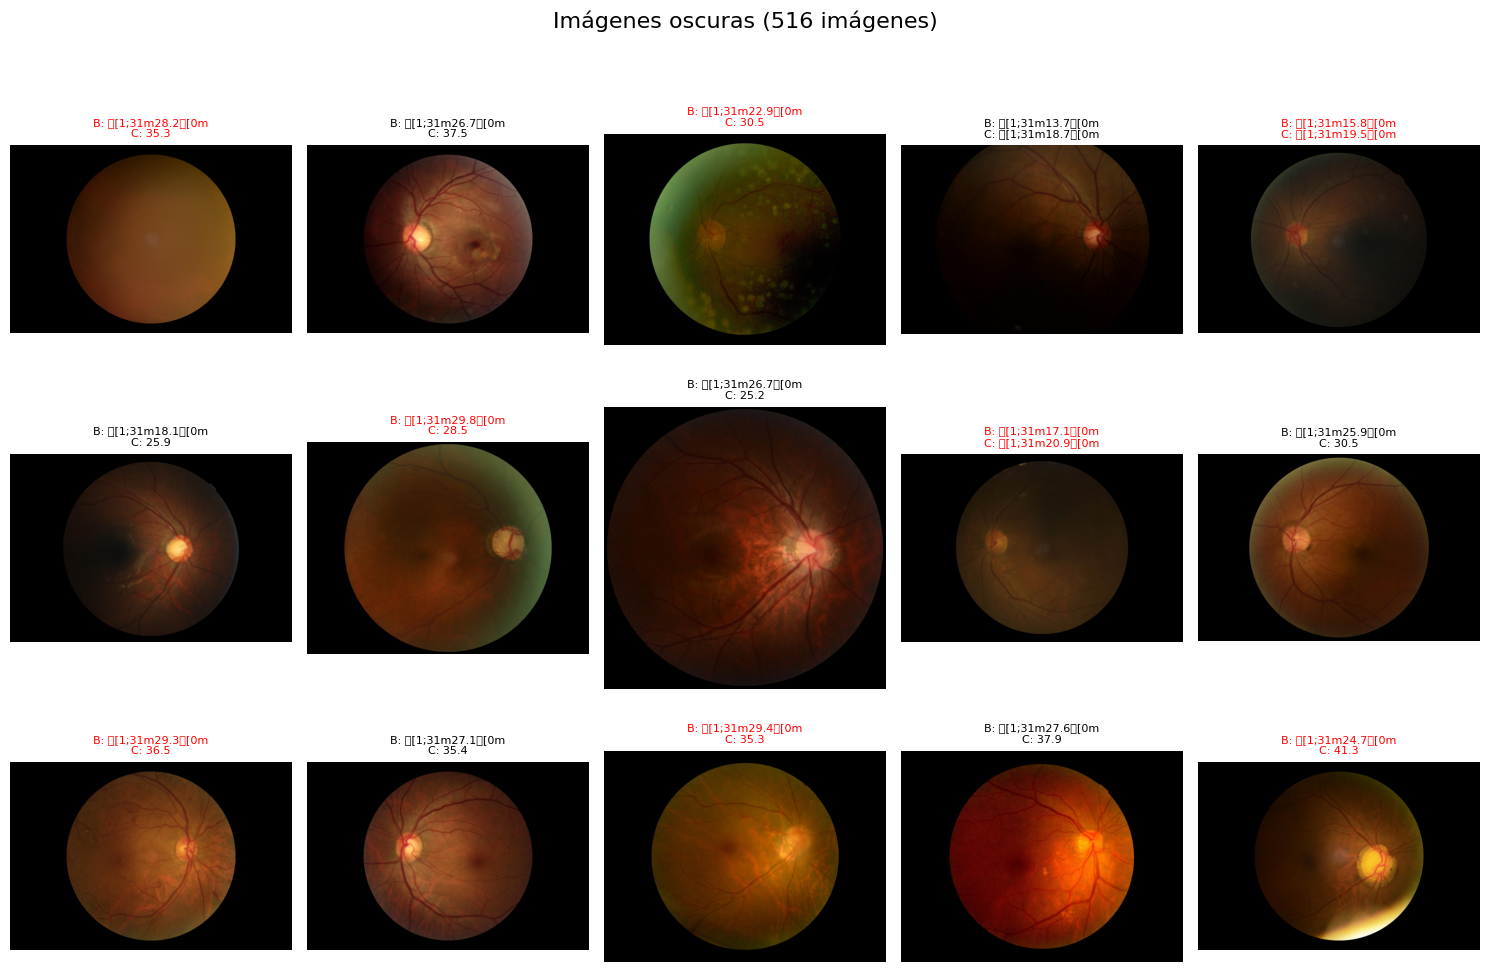

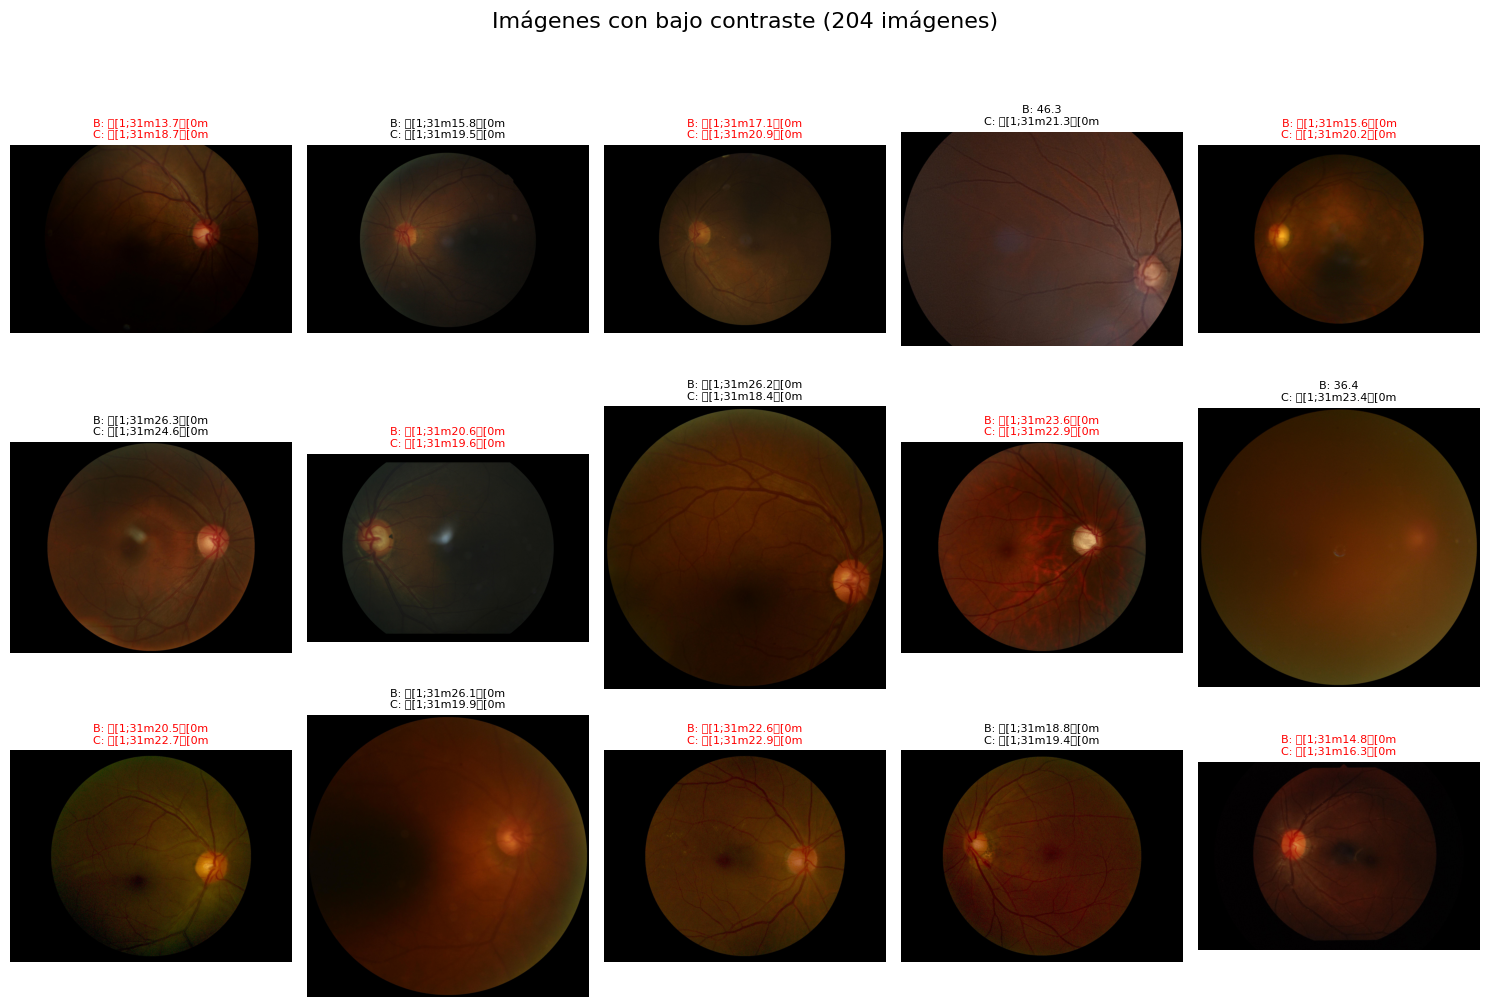

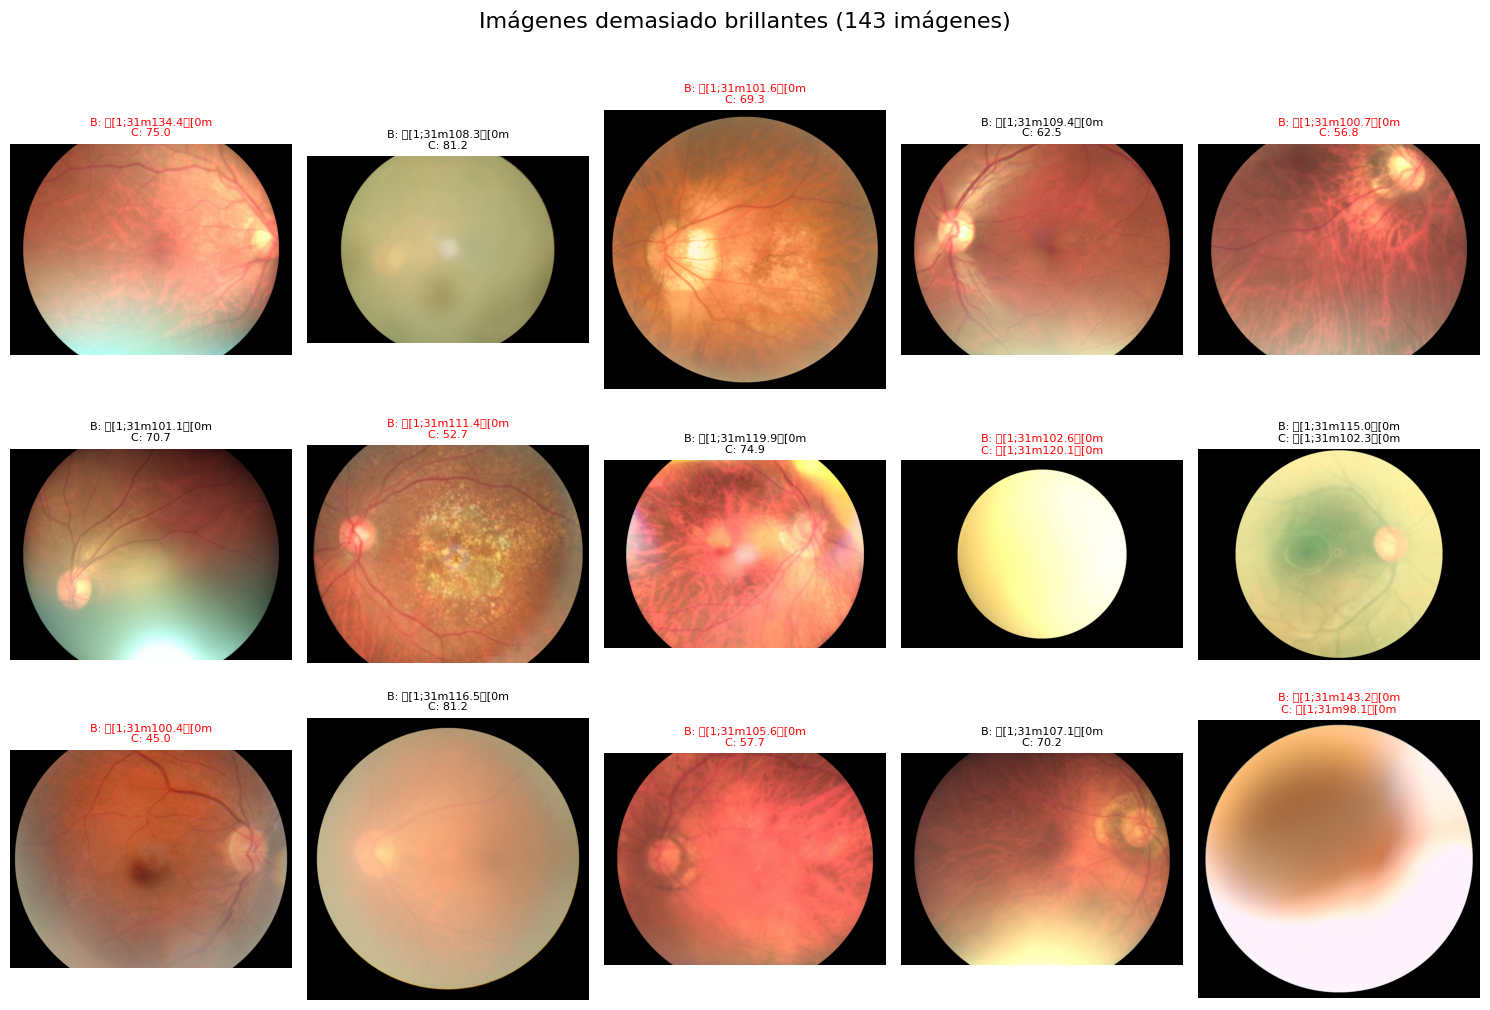

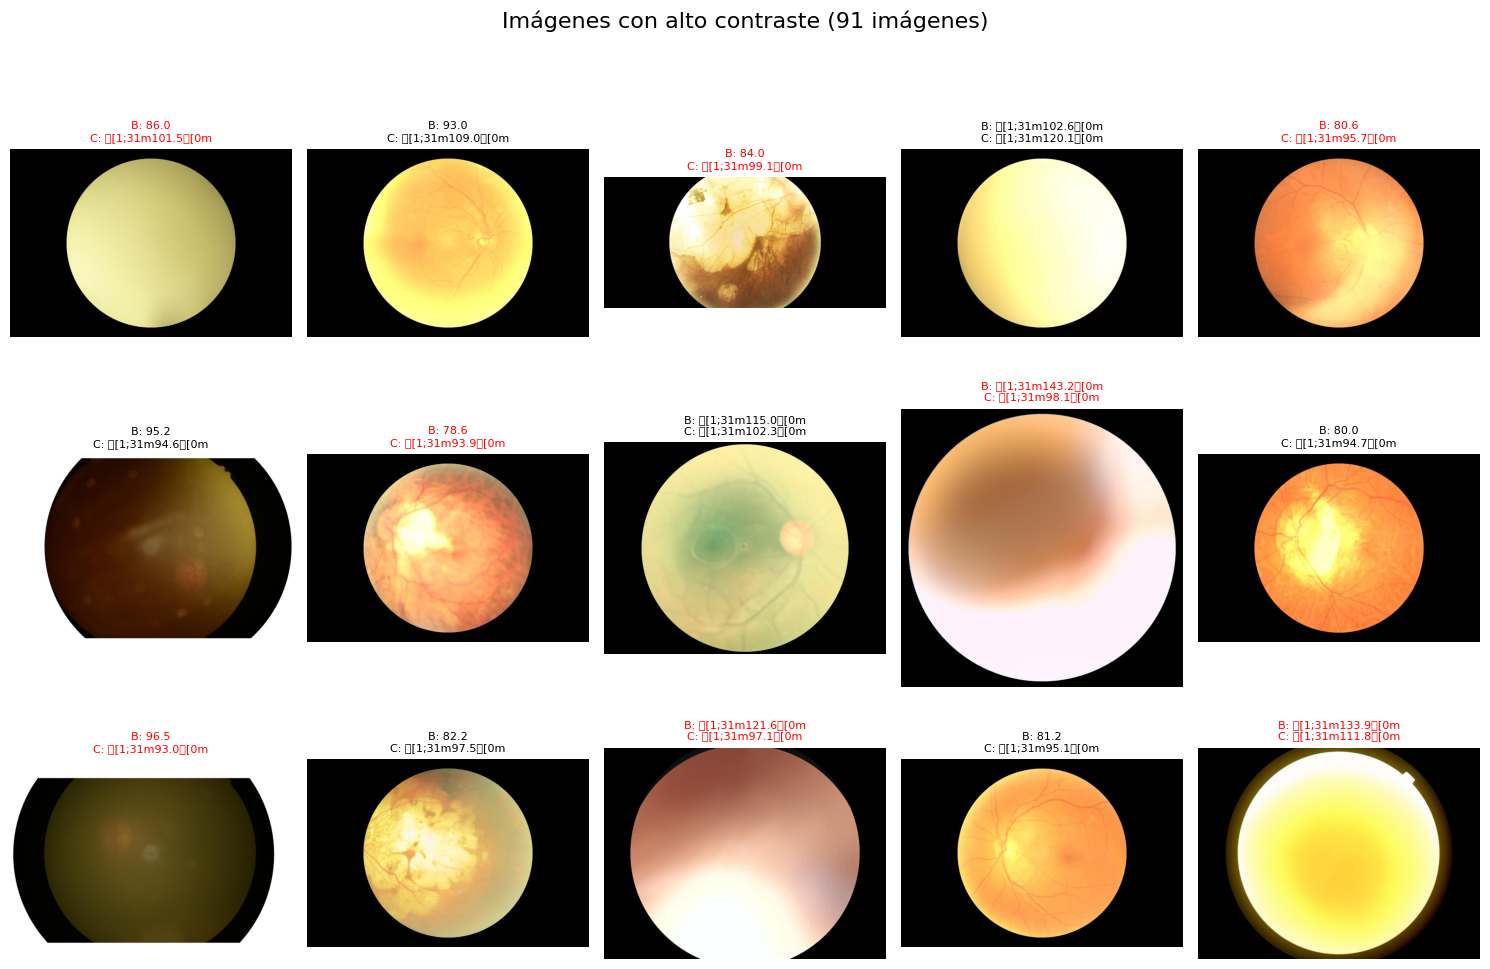

In [5]:
def display_examples(image_paths, title, max_examples=15):
    """Muestra un grid con ejemplos de imágenes problemáticas"""
    if not image_paths:
        print(f"No hay imágenes para mostrar en la categoría: {title}")
        return
    
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"{title} ({len(image_paths)} imágenes)", y=1.02, fontsize=16)
    
    # Limitar el número de ejemplos y calcular el grid
    examples = image_paths[:max_examples]
    rows = int(np.ceil(len(examples)/5))
    
    for i, path in enumerate(examples, 1):
        plt.subplot(rows, 5, i)
        img = cv2.imread(path)
        if img is None:
            continue
            
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis('off')
        
        # Calcular métricas
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness = np.mean(gray)
        contrast = np.std(gray)
        
        # Resaltar en rojo las métricas problemáticas
        brightness_text = f"B: {brightness:.1f}"
        contrast_text = f"C: {contrast:.1f}"
        
        if brightness < THRESHOLDS['dark'] or brightness > THRESHOLDS['bright']:
            brightness_text = f"B: \033[1;31m{brightness:.1f}\033[0m"
        if contrast < THRESHOLDS['low_contrast'] or contrast > THRESHOLDS['high_contrast']:
            contrast_text = f"C: \033[1;31m{contrast:.1f}\033[0m"
        
        plt.title(f"{brightness_text}\n{contrast_text}", fontsize=8, color='red' if i % 2 else 'black')
    
    plt.tight_layout()
    plt.show()

# Mostrar ejemplos de todas las categorías
categories = {
    'dark': "Imágenes oscuras",
    'low_contrast': "Imágenes con bajo contraste",
    'bright': "Imágenes demasiado brillantes", 
    'high_contrast': "Imágenes con alto contraste"
}

for category, title in categories.items():
    if stats[f'{category}_images'] > 0:
        display_examples(stats[f'{category}_paths'], title)

### Distribución de las imágenes oscuras y bajo contraste por clase

En esta sección se analiza cómo se distribuyen las imágenes oscuras y con bajo contraste entre las diferentes clases diagnósticas. Esto permite identificar si ciertas patologías están asociadas con una mayor frecuencia de imágenes de baja calidad, lo cual podría influir en el rendimiento del modelo y requerir estrategias específicas de preprocesamiento.

In [7]:
# Crear DataFrame de calidad de imágen 
quality_data = []
for idx, row in df.iterrows():
    img_path = os.path.join(train_dir, row['filename'])
    analysis = analyze_image_quality(img_path)
    if analysis:
        quality_data.append({
            'filename': row['filename'],
            'brightness': analysis['brightness'],
            'contrast': analysis['contrast'],
            'is_dark': analysis['is_dark'],
            'is_low_contrast': analysis['is_low_contrast'],
            'labels': row['labels'] 
        })

quality_df = pd.DataFrame(quality_data)

labels_expanded = quality_df['labels'].apply(lambda x: ''.join(eval(x)) if isinstance(x, str) else ''.join(x)).str.get_dummies()
quality_df = pd.concat([quality_df.drop('labels', axis=1), labels_expanded], axis=1)

NameError: name 'analyze_image_quality' is not defined

In [ ]:
quality_df.head(5)

filename  brightness   contrast  is_dark  is_low_contrast  A  C  D  G  \
0  0_right.jpg   33.274280  30.609474    False             True  0  0  0  0   
1  1_right.jpg   53.834958  65.333838    False            False  0  0  0  0   
2  2_right.jpg   34.812584  35.673807    False            False  0  0  1  0   
3  4_right.jpg   50.609196  64.242010    False            False  0  0  1  0   
4  5_right.jpg   71.283488  57.147460    False            False  0  0  1  0   

   H  M  N  O  
0  0  0  1  0  
1  0  0  1  0  
2  0  0  0  0  
3  0  0  0  0  
4  0  0  0  0

/var/folders/7z/6sq72d5x0s948s3fwhhpbthh0000gn/T/ipykernel_2576/2617939167.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Disease', y='% Dark', data=pct_dark_df, palette='viridis')


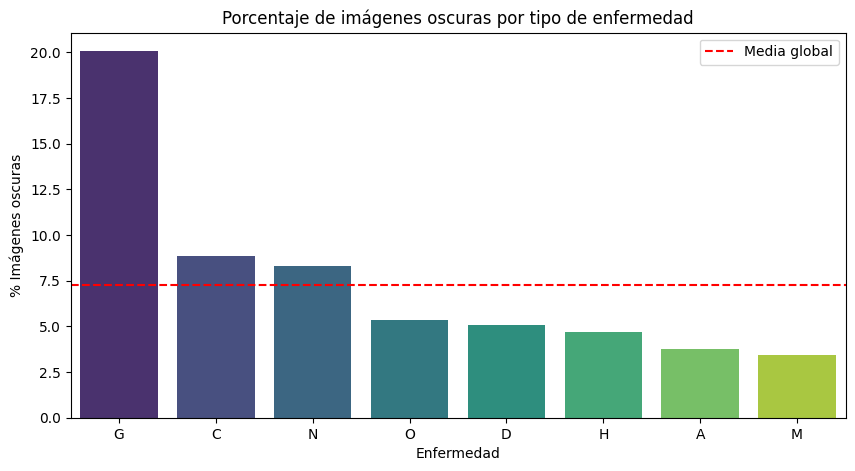

In [ ]:
# Lista de enfermedades
diseases = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Calcular % de imágenes oscuras por enfermedad #(Leti): yo pondfía por clase no?, ya que también estamos evaluando las sanas (N)
results = []
for disease in diseases:
    total = quality_df[disease].sum()
    dark = quality_df[(quality_df[disease] == 1) & (quality_df['is_dark'])].shape[0]
    pct = (dark / total) * 100 if total > 0 else 0
    results.append({'Disease': disease, 'Total': total, 'Dark': dark, '% Dark': pct})

pct_dark_df = pd.DataFrame(results).sort_values('% Dark', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Disease', y='% Dark', data=pct_dark_df, palette='viridis')
plt.title('Porcentaje de imágenes oscuras por tipo de clase') # lo mismo: por clase 
plt.xlabel('Clase') # Clase 
plt.ylabel('% Imágenes oscuras')
plt.axhline(y=quality_df['is_dark'].mean() * 100, color='red', linestyle='--', 
            label='Media global')
plt.legend()
plt.show()

En la gráfica de arriba vemos que la mayoría de las imágenes oscuras corresponden a la enfermedad de "Glaucoma", por lo que, a priori, sería más recomendable intentar modificar dichas imágenes en lugar de eliminarlas direactamente. Par el resto se poría considerar que es un número aceptable, o bastante bajo, de imágenes oscuras.

/var/folders/7z/6sq72d5x0s948s3fwhhpbthh0000gn/T/ipykernel_2576/1755338292.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Disease', y='% Low Contrast', data=pct_low_contrast_df, palette='crest')


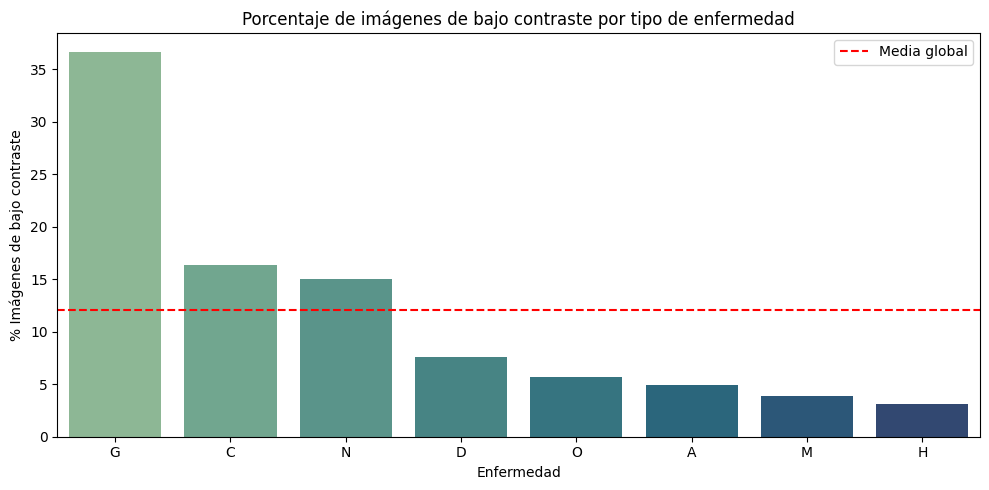

In [ ]:
# Enfermedades presentes en el dataset  # (Leti): añado gráfica también para bajo contraste
diseases = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Calcular % de imágenes de bajo contraste por enfermedad
results_contrast = []
for disease in diseases:
    total = quality_df[disease].sum()
    low_contrast = quality_df[(quality_df[disease] == 1) & (quality_df['is_low_contrast'])].shape[0]
    pct = (low_contrast / total) * 100 if total > 0 else 0
    results_contrast.append({'Disease': disease, 'Total': total, 'Low Contrast': low_contrast, '% Low Contrast': pct})

# Crear DataFrame ordenado por % bajo contraste
pct_low_contrast_df = pd.DataFrame(results_contrast).sort_values('% Low Contrast', ascending=False)

# Gráfico
plt.figure(figsize=(10, 5))
sns.barplot(x='Disease', y='% Low Contrast', data=pct_low_contrast_df, palette='crest')
plt.title('Porcentaje de imágenes de bajo contraste por clase')
plt.xlabel('Clase')
plt.ylabel('% Imágenes de bajo contraste')
plt.axhline(y=quality_df['is_low_contrast'].mean() * 100, color='red', linestyle='--', 
            label='Media global')
plt.legend()
plt.tight_layout()
plt.show()

Observamos de nuevo que la mayoría de imágenes que presentan un bajo contraste corresponden a la enfermedad de "Glaucoma".

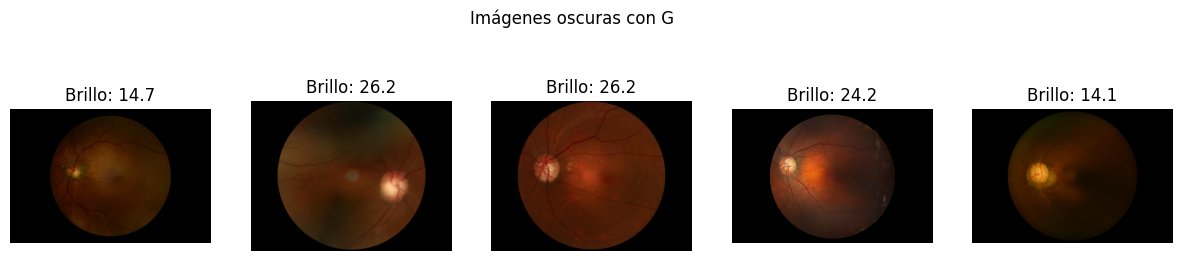

In [ ]:
def plot_dark_images_by_disease(disease, n_samples=5):
    """
    Muestra ejemplos de imágenes oscuras asociadas a una clase diagnóstica específica.

    Parámetros:
        disease (str): Código de la enfermedad (por ejemplo, 'G' para glaucoma).
        n_samples (int): Número de imágenes oscuras a visualizar.
    """
    dark_samples = quality_df[(quality_df[disease] == 1) & 
                            (quality_df['is_dark'])].sample(n_samples)
    
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(dark_samples.iterrows()):
        img = cv2.imread(os.path.join(train_dir, row['filename']))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n_samples, i+1)
        plt.imshow(img)
        plt.title(f"Brillo: {row['brightness']:.1f}")
        plt.axis('off')
    plt.suptitle(f'Imágenes oscuras con {disease}', y=1.05)
    plt.show()

# Ejemplo para glaucoma ('G')
plot_dark_images_by_disease('G')

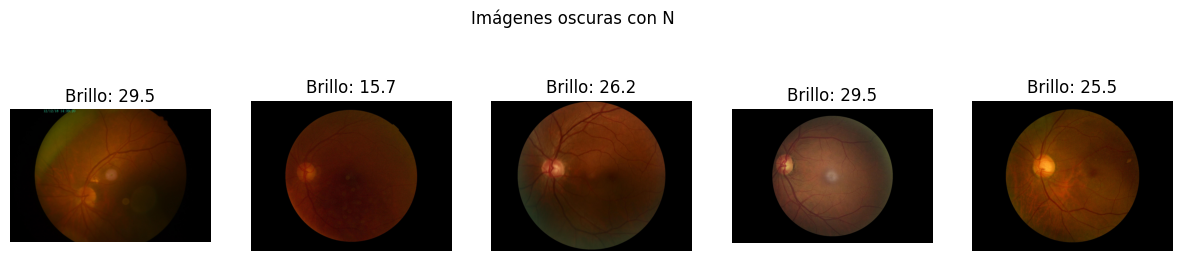

In [ ]:
# Ejemplo para Normal ('N')
plot_dark_images_by_disease('N')

In [ ]:
tabla_pct_oscuras = pct_dark_df.rename(columns={
    'Disease': 'Clase',
    'Total': 'Total imágenes',
    'Dark': 'Imágenes oscuras',
    '% Dark': '% oscuras'
})
display(tabla_pct_oscuras[['Clase', 'Total imágenes', 'Imágenes oscuras', '% oscuras']])

Clase  Total imágenes  Imágenes oscuras  % oscuras
2     G             284                57  20.070423
3     C             293                26   8.873720
0     N            2873               239   8.318830
7     O             708                38   5.367232
1     D            1608                82   5.099502
5     H             128                 6   4.687500
4     A             266                10   3.759398
6     M             232                 8   3.448276

Se observa que la clase G (Glaucoma) presenta el mayor porcentaje de imágenes oscuras, con un 20,1 % del total, lo cual representa una diferencia significativa respecto al resto de clases. Le siguen las clases C (Catarata) y N (Fondo normal) con aproximadamente un 9 % y 8,3 %, respectivamente. Las demás clases muestran porcentajes considerablemente más bajos, por debajo del 6 %.

Este desequilibrio sugiere que ciertas patologías podrían estar más afectadas por problemas de iluminación en las imágenes, algo que habrá que tenr en cueta a la hora de definir las estrategias específicas de preprocesamiento para compensar esta variabilidad., por ejemplo aplicando `ColorJitter (brightness)` o CLAHE (ecualización adaptativa del histograma), antes de considerar elliminarlas.

A continuación mostramos un boxplot que muestra la distribución del brillo de las imágenes según la presencia o ausencia de cada enfermedad. los colores diferencia si la imagen tiene o no la enfermedad (1: la tiene, o: no la tiene).

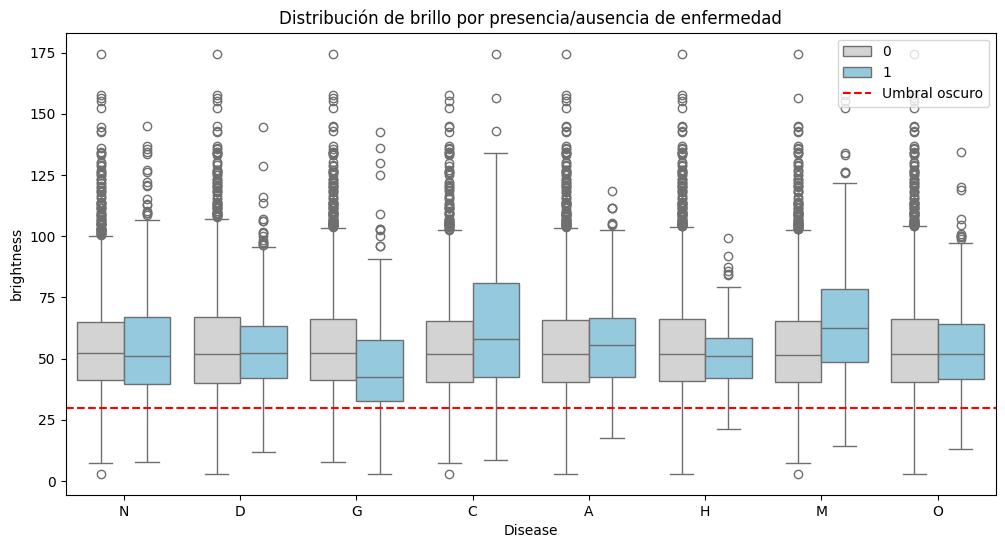

In [ ]:
# distribucion de brillo por enfermedad
plt.figure(figsize=(12, 6))
sns.boxplot(data=quality_df.melt(id_vars=['brightness'], 
                                value_vars=diseases, 
                                var_name='Disease', 
                                value_name='HasDisease'),
            x='Disease', 
            y='brightness', 
            hue='HasDisease',
            palette={0: 'lightgray', 1: 'skyblue'})
plt.title('Distribución de brillo por presencia/ausencia de enfermedad')
plt.axhline(y=DARK_THRESHOLD, color='red', linestyle='--', label='Umbral oscuro')
plt.legend()
plt.show()

Aplicamos un test estadístico (t-test independiente) para comparar si hay diferencias significativas en el brillo medio entre imágenes con y sin cada una de las enfermedadades.

In [ ]:
# Comparación de brillo entre grupos con y sin enfermedad
for disease in diseases:
    group1 = quality_df[quality_df[disease] == 1]['brightness']
    group0 = quality_df[quality_df[disease] == 0]['brightness']
    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)
    print(f"{disease}: p-value = {p_val:.4f} (Brillo medio: {group1.mean():.1f} vs {group0.mean():.1f})")

N: p-value = 0.0164 (Brillo medio: 53.9 vs 55.0)
D: p-value = 0.0718 (Brillo medio: 53.8 vs 54.7)
G: p-value = 0.0000 (Brillo medio: 46.8 vs 54.9)
C: p-value = 0.0000 (Brillo medio: 62.8 vs 54.1)
A: p-value = 0.0611 (Brillo medio: 56.6 vs 54.4)
H: p-value = 0.0208 (Brillo medio: 51.6 vs 54.6)
M: p-value = 0.0000 (Brillo medio: 65.9 vs 54.1)
O: p-value = 0.7572 (Brillo medio: 54.3 vs 54.5)


Perece que hay evidencia estadística de que algunas enfermedades se asocian con diferencias en el brillo medio:

G (glaucoma): brillo significativamente más bajo.

C (cataratas), M (miopía): brillo significativamente más alto.

Lo que nos confirma que sería recomendable normalizar el brillo.

En esta sección se visualizan los valores medios de brillo y contraste por clase diagnóstica mediante un mapa de calor. Esta representación permite identificar de forma rápida si existen patrones sistemáticos de calidad visual (imágenes más oscuras o con menor contraste) asociados a determinadas enfermedades

In [ ]:
# Lista de clases del dataset
diseases = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Crear una tabla con brillo y contraste medios por clase
heatmap_data = []

for disease in diseases:
    subset = quality_df[quality_df[disease] == 1]
    heatmap_data.append([
        disease,
        subset['brightness'].mean(),
        subset['contrast'].mean()
    ])

# Convertimos a DataFrame
heatmap_df = pd.DataFrame(heatmap_data, columns=['Disease', 'Brightness', 'Contrast'])
heatmap_df.set_index('Disease', inplace=True)

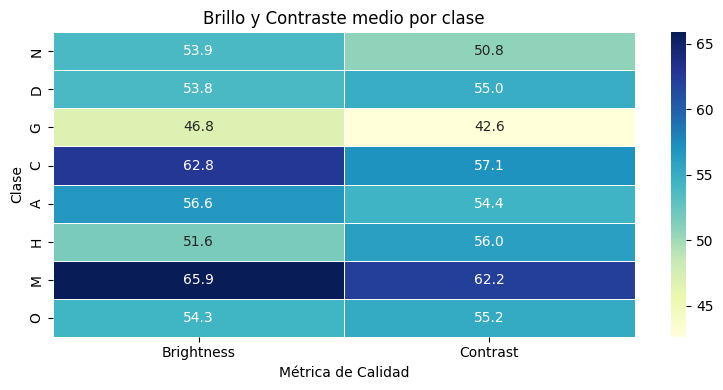

In [ ]:
# Graficamos el heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_df, annot=True, cmap='YlGnBu', fmt=".1f", linewidths=0.5)
plt.title("Brillo y Contraste medio por clase")
plt.ylabel("Clase")
plt.xlabel("Métrica de Calidad")
plt.tight_layout()
plt.show()

## Propuestas para la transformación de imágenes, creacón de Dataloader o arquitectura (a valorar conjuntamente)

A partir del análisis de imágenes, se proponen las siguientes acciones, sin perjuicio de considerar otras adicionales:

---

### 1. Posible eliminación de las imágenes consideradas oscuras 

- Total afectado: **620 imágenes** (~**7,8%** del total).
- Opción: no eliminar directamente, si ese porcentaje se concentra en una clase concreta (por ejemplo la G), estaríamos introduciendo un sesgo (ver primero qué procentaje que representaría de cada clase). Pueden ser útiles aunque tengan mal preprocesado?. Probar aplicando primero trasnsformaciones con ColorJitter(brightness). O tambien, aplicar sample_weight para darles menos importancia en el entrenamiento.

---

### 2. Mejora mediante ecualización CLAHE
_Aplicable sobre el dataset completo o solo sobre imágenes de bajo contraste._

**Pros:**
- Mejora la detección de elementos poco visibles como **microaneurismas, neovasos o exudados**  
  _(no drusas, dado que no se trata de imágenes OCT)_.
- Ajuste local del contraste por zonas.
- Mejora del brillo (a priori, ya en buenos valores).

**Contras:**
- Puede amplificar el ruido en algunos casos. Riesgo de falsos positivos.
- Método "manual" mediante *clip limit* para limitar la redistribución del histograma.
- No garantiza una mejora en el rendimiento del modelo.
- No es tan eficaz como parece si no se combina con segmentación (por ejemplo, si partes oscuras son grandes).

---

### 3. Tamaño de redimensionamiento de las imágenes

Existe una **variedad importante de tamaños** en las imágenes.

- El tamaño más frecuente es **(1728, 2592, 3)** → **2.420 imágenes (~30%)**

  > Redimensionando a este tamaño y considerando un total de ~4.500 imágenes para entrenamiento,  
  > se estima una duración de **~20 minutos** en GCP con **GPU T4** (ResNet18, batch=16, 20 epochs)  
  > _(valoración aproximada según Gemini y ChatGPT)_.
  > Contras: Redimensionar a (1728, 2592) como estándar no es óptimo: Es demasiado grande para la mayoría de arquitecturas preentrenadas y costoso.
     Fuerzas el modelo a aprender detalles innecesarios a gran resolución y puede sobreajustar.

  - Si se detectan cuellos de botella, considerar el uso de **GPUs superiores** como la **V100**.

- Alternativamente, se puede **reducir el tamaño** para ganar agilidad inicial y evitar:
  - pérdida de nitidez,
  - amplificación de ruido al escalar imágenes pequeñas.
  - Para redes tio ResNet puede ser conveniente usar: Resize + CenterCrop. El centro de la retina se mantiene, no se distorsiona la imagen.

  **Tamaños sugeridos:**
  - `1024 x 1024` (cuadrado). Solo para fine-tuning en modelos propios
  - `896 x 1344` (proporción ≈ 2:3). Si se entrena desde cero.
  - Ante de tomar esta decisión es importante definiar antes la arquitectura que vamos a usar. Alinear el tamaño propuesto con la arquitectura final. Por ejemplo:

      - 224×224 (ResNet18, MobileNet)

      - 380×380 (EfficientNet-B4)

  > Riesgo: pérdida de detalle.  
  > En el caso del formato rectangular, tener en cuenta que algunos modelos usan *flatten* fijo.  
  > Por ejemplo, **ResNet18** es compatible. 

---

### 4. Tipo de redimensionamiento

Comparativa entre métodos:

- **`cv2.resize`**  
  - Redimensionamiento directo.  
  - Puede **deformar** las imágenes y perder información relevante.
  - No es reocmendable en clasificación con emágenes donde la forma importa.

- **`resize` + padding**  
  - Ajusta las imágenes con relleno.  
  - No distorsiona, pero puede **introducir ruido** (usar colores neutros).
  - Es mejor para arquitecturas que requierenm entrada cuadrada.
  - El relleno es artificial y puede actuar como ruido visual o generar bordes dominantes, especialmente si:

      - Hay mucho padding relativo al área útil.

      - El modelo no está regularizado adecuadamente.

- **transforms.Resize con relación de aspecto + CenterCrop**
  - Más robusto para mantener proporción y evitar bordes artificiales.
  - Mantiene la región central, evita distorsión, y sin relleno artificial.

---

### 5. Simetría de las imégenes

- Asegurar que los imágenes de ojo derecho e izquierdo no están invertidos entre sí. Aplicar RandomHorizontalFlip().

---

### 6. Aumento cromático con Data augmentation

- Debido al porcentaje significativo de imágenes (12%) con bajo contraste, podríamos valorar usar ColorJitter (contrast y saturación). Usar con cuidado dado que puede generar colores articiales poco representativos.

---

### 7. Balance de clases

- Abordar problema de desbalance de clases:

    - WeightedRandomSampler en el DataLoader

    - Pérdida ponderada (class_weight)

    - Oversampling.

---